# Chapter 8

In [205]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,summarize)
from sklearn.tree import (DecisionTreeClassifier as DTC,DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,GradientBoostingRegressor as GBR,
                             GradientBoostingClassifier as GBC,
                             BaggingClassifier as BC)
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression 
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

## Exercise 7

In [2]:
Boston=load_data("Boston")

In [4]:
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [122]:
#We preserve the same dimensions of the test set as the lab
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,Boston['medv'],test_size=0.5,
                                                          random_state=30)

In [133]:
#We should vary the number of trees from 1 to 100 as the figure 8.10 did in the book
k=0
MSE=np.zeros((30,3))
for t in range(10,600,20):
    RF_Boston1=RF(max_features=1.0,n_estimators=t,random_state=30).fit(X_train,y_train)
    RF_Boston2=RF(max_features=0.5,n_estimators=t,random_state=30).fit(X_train,y_train)
    RF_Boston3=RF(max_features='sqrt',n_estimators=t,random_state=30).fit(X_train,y_train)
    ypred1=RF_Boston1.predict(X_test)
    ypred2=RF_Boston2.predict(X_test)
    ypred3=RF_Boston3.predict(X_test)
    MSE[k,0]=np.mean((y_test - ypred1)**2)
    MSE[k,1]=np.mean((y_test - ypred2)**2)
    MSE[k,2]=np.mean((y_test - ypred3)**2)
    k+=1


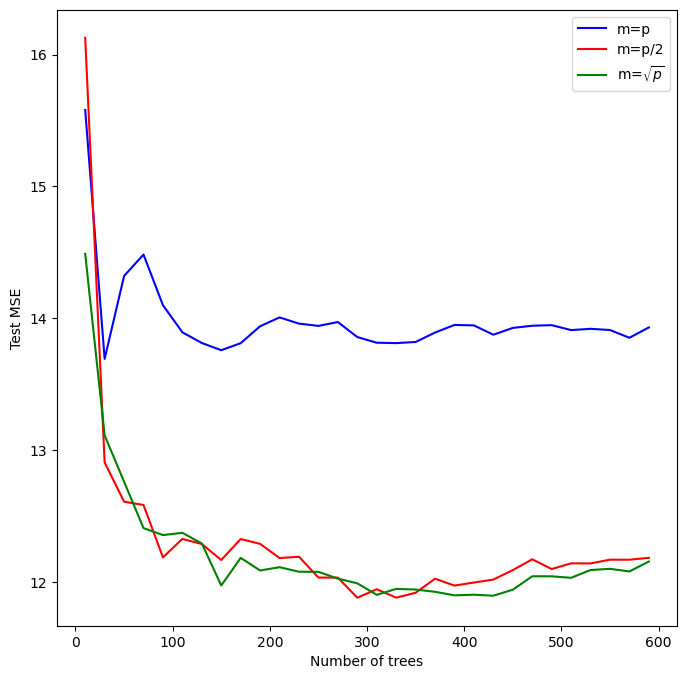

In [136]:
plot_idx = np.arange(10,600,20)
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,MSE[:,0],'b',label='m=p')
ax.plot(plot_idx,MSE[:,1],'r',label='m=p/2')
ax.plot(plot_idx,MSE[:,2],'g',label='m=$\sqrt{p}$')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Test MSE')
ax.legend();

We notice that the test MSE is improved as the number of trees increases. Moreover, better results are obtained when the number of selected features is close to $\sqrt{p}$ and $p/2$

## Exercise 8

In [2]:
Carseats=load_data('Carseats')

In [3]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

### (a)

In [4]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,Carseats['Sales'],test_size=0.5,
                                                          random_state=30)

### (b)

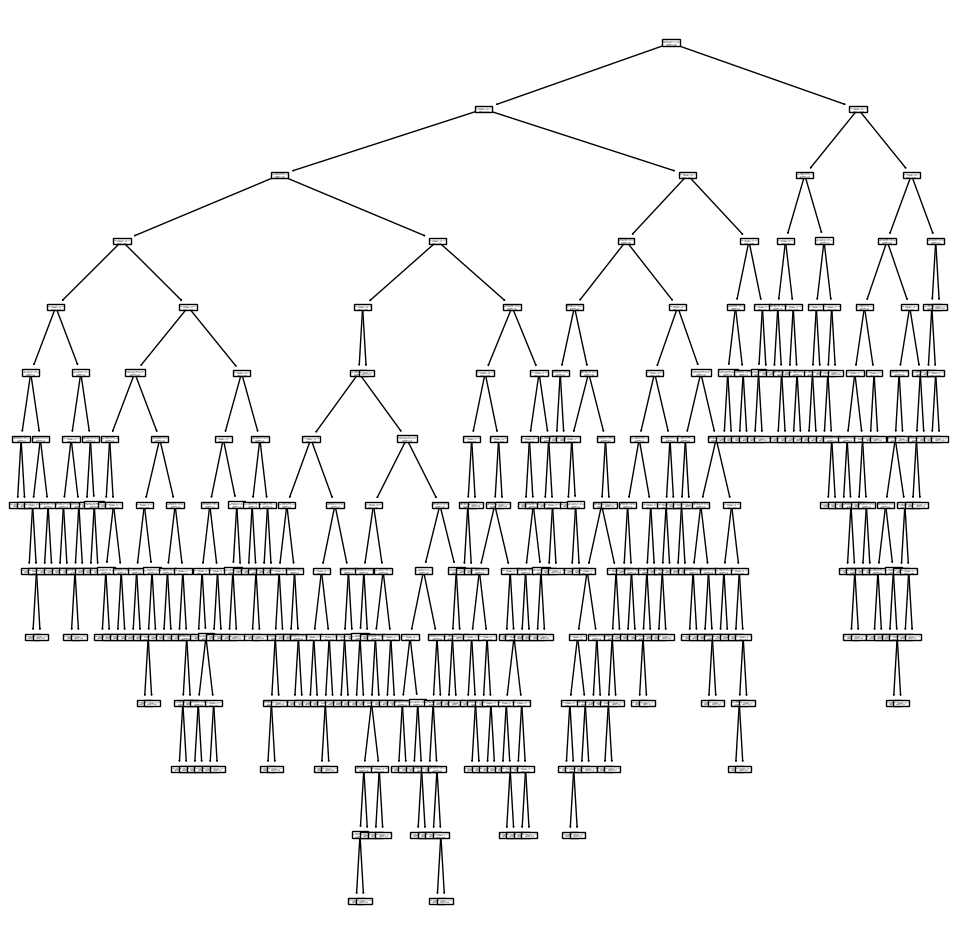

In [6]:
reg = DTR()
result=reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,feature_names=feature_names,ax=ax);

In [8]:
ypred=result.predict(X_test)
MSE=np.mean((ypred-y_test)**2)
MSE

5.5790715

In [12]:
result.get_depth()

13

The test MSE is 5.56.<br>
We have let The depth of the regression tree to be automatically obtained untill all the nodes are pure. The depth is finally 13.

### (c)

In [13]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,shuffle=True,random_state=35)
grid = skm.GridSearchCV(reg,{'ccp_alpha': ccp_path.ccp_alphas},refit=True,cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [18]:
grid.best_estimator_.ccp_alpha

0.09846073636363178

The best tuning $\alpha$ parameter obtained by corss-validation is 0.098

In [20]:
best_model=grid.best_estimator_
pruning_MSE=np.mean((y_test-best_model.predict(X_test))**2)
pruning_MSE

4.997636769696412

The cost complexity pruning yiealds to a test MSE of approximately 5 which is better than the test MSE previously obtained on the full regression tree.

### (d)

In [21]:
bag_seats = RF(max_features=X_train.shape[1], random_state=36)
bag_seats.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=36)

In [22]:
bag_MSE=np.mean((y_test - bag_seats.predict(X_test))**2)
bag_MSE

2.6145821358499997

In [26]:
df=pd.DataFrame({'importance':bag_seats.feature_importances_},index=feature_names)
df.sort_values(by='importance', ascending=False)

,importance
Price,0.291835
ShelveLoc[Good],0.211079
Income,0.103316
Age,0.098761
CompPrice,0.095919
Advertising,0.056774
ShelveLoc[Medium],0.050990
Population,0.044953
Education,0.031706
Urban[Yes],0.009492


The test MSE is nearly halved after use of bagging. Moreover, the top 3 most important predictors of Sales are: Price, ShelveLoc and Income.

### (e)

In [40]:
#As for the previous exercise, we will change the number of features among p, p/2 and sqrt(p)
RF_MSE=np.zeros((1,3))
RF_seats1=RF(max_features=1.0,random_state=0).fit(X_train,y_train)
RF_seats2=RF(max_features=0.5,random_state=0).fit(X_train,y_train)
RF_seats3=RF(max_features='sqrt',random_state=0).fit(X_train,y_train)
ypred1=RF_seats1.predict(X_test)
ypred2=RF_seats2.predict(X_test)
ypred3=RF_seats3.predict(X_test)
RF_MSE[0,0]=np.mean((y_test - ypred1)**2)
RF_MSE[0,1]=np.mean((y_test - ypred2)**2)
RF_MSE[0,2]=np.mean((y_test - ypred3)**2)


In [41]:
RF_MSE

array([[2.57109663, 2.75792513, 3.04815656]])

The best obaitned test MSE with random forests is around 2.60 which is practically the same for bagging.<br>
Changing m has resulted in the change of test MSE form 2.60 to 3.05. 

In [43]:
df=pd.DataFrame({'importance':RF_seats1.feature_importances_},index=feature_names)
df.sort_values(by='importance', ascending=False)

,importance
Price,0.296556
ShelveLoc[Good],0.214089
Income,0.101554
CompPrice,0.100222
Age,0.089137
Advertising,0.056200
ShelveLoc[Medium],0.051287
Population,0.045874
Education,0.031734
Urban[Yes],0.008122


As for the previous question, the most important features in Sales prediction are: Price, ShelveLoc and Income.

### (f)

In [53]:
#The predefined BART class defined in ISLP contains an error in the fit function
#Here we import the updated bart file, downloaded from Jonathan Taylor's github repo
import bart

In [54]:
bart_seats = bart.BART(random_state=0, burnin=5, ndraw=15)
bart_seats.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [55]:
yhat_test = bart_seats.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

1.3024315144273175

The test MSE obtained with BART is 1.30, which is half of both random forests and bagging approaches.We can see then that BART is truly competitive.

## Exercise 9

In [2]:
oj=load_data("OJ")

In [3]:
oj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase        1070 non-null   object 
 1   WeekofPurchase  1070 non-null   int64  
 2   StoreID         1070 non-null   int64  
 3   PriceCH         1070 non-null   float64
 4   PriceMM         1070 non-null   float64
 5   DiscCH          1070 non-null   float64
 6   DiscMM          1070 non-null   float64
 7   SpecialCH       1070 non-null   int64  
 8   SpecialMM       1070 non-null   int64  
 9   LoyalCH         1070 non-null   float64
 10  SalePriceMM     1070 non-null   float64
 11  SalePriceCH     1070 non-null   float64
 12  PriceDiff       1070 non-null   float64
 13  Store7          1070 non-null   object 
 14  PctDiscMM       1070 non-null   float64
 15  PctDiscCH       1070 non-null   float64
 16  ListPriceDiff   1070 non-null   float64
 17  STORE           1070 non-null   i

In [4]:
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [5]:
#By simple conditionning below we check that STORE contains dummy varaibles of the Store7 feature
# By displaying the data set we suspect that whenever Store7=='Yes', STORE==0
len(oj[((oj['Store7']=='Yes') & (oj['STORE']==1)) | ((oj['Store7']=='No') & (oj['STORE']==0))])

0

In [6]:
#We conclude from the previous line that STORE contains dummy variables of Store
model = MS(oj.columns.drop(['Purchase','Store7']), intercept=False)
D = model.fit_transform(oj)
feature_names = list(D.columns)
X = np.asarray(D)

### (a)

In [7]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,oj['Purchase'],train_size=800,
                                                          random_state=0)

### (b)

In [8]:
clf = DTC(criterion='entropy', random_state=0)
result=clf.fit(X_train, y_train)

In [9]:
training_error=1-accuracy_score(y_train, clf.predict(X_train))
training_error

0.008750000000000036

The training error rate is 0.87%, which is very low. We suspect that model overfitted the data.

### (c)

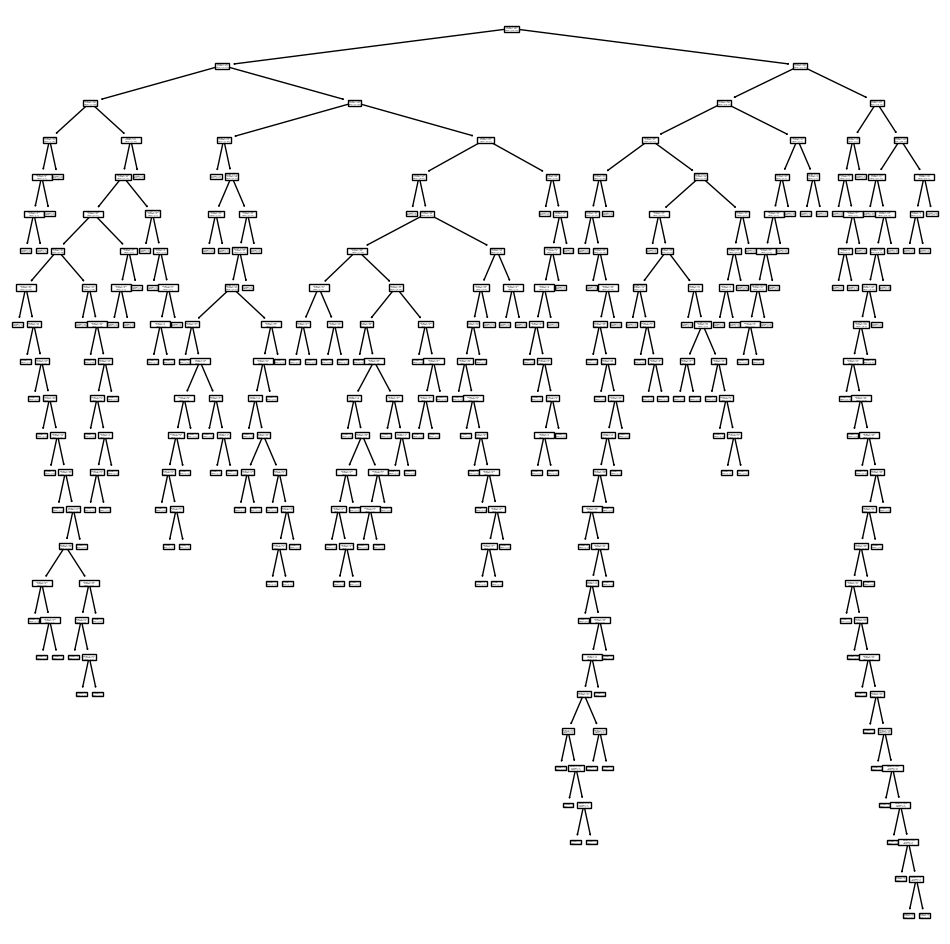

In [10]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,feature_names=feature_names,ax=ax);

In [11]:
clf.tree_.n_leaves

171

Since we fitted the model using the maximal number of subtrees, the plot is hardly interpretable.<br>
The number of terminal nodes is 171.

### (d)

In [12]:
print(export_text(clf,feature_names=feature_names,show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |--- WeekofPurchase <= 267.50
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: MM
|   |   |   |   |   |--- WeekofPurchase >  267.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |--- weights: [0.00, 3.00] class: MM
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- weights: [0.00, 43.00] class: MM
|   |   |--- LoyalCH >  0.04
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- SalePriceCH <= 1.94
|   |   |   |   |   |--- WeekofPurchase <= 263.50
|   |   |   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |   |   |--- WeekofPurchase <= 228.00
|   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |   |   |   |--- WeekofPurchase >  228.00
|   |   |   |   |   |   |   |   |--- LoyalCH

Let's take for instance the first terminal node shown in the previous output.<br>
That node was classified as MM based on 2 votes over nil. It was obtained after splitting feature LoyalCH thrice, StoreID once and WeekofPurchase twice. Basically, it conveys that any Purchase for which $LoyalCH \le 0,04, \;  StoreID \le 2,50\;and\;  WeekofPurchase \le 267,50$ is classified as $MM$.

### (e)

In [13]:
confusion = confusion_table(clf.predict(X_test),y_test)
confusion

Truth,CH,MM
Predicted,,
CH,126,33
MM,27,84


In [23]:
test_error=(confusion.iloc[0,1]+confusion.iloc[1,0])/np.sum(confusion.values)
test_error

0.2222222222222222

The test error is 22,22%, which is way higher than training error. The suspected overfitting is confirmed, we should look for the optimal tree size.

### (f)

In [39]:
M=np.zeros(clf.get_depth())
for i in range(1,clf.get_depth()+1):
    clf1 = DTC(criterion='entropy', random_state=20,max_depth=i)
    results1 = skm.cross_val_score(clf1,X_train,y_train,cv=10)#10-fold
    M[i-1]=results1.mean()
print('The optimal tree size is',M.argmax()+1)

The optimal tree size is 3


### (g)

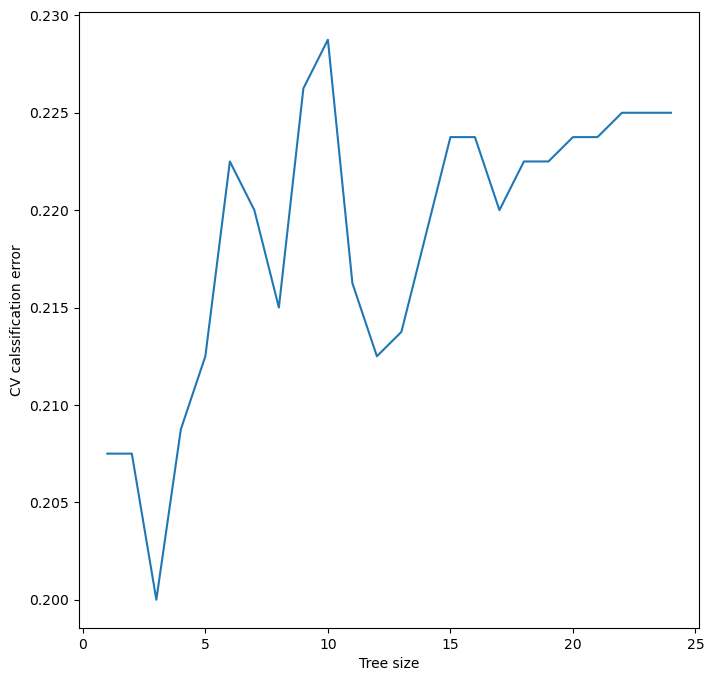

In [41]:
fig,ax=subplots(figsize=(8,8))
ax.plot(range(1,clf.get_depth()+1),1-M)
ax.set_xlabel("Tree size")
ax.set_ylabel("CV calssification error");

### (h)

The best tree size is 3.

### (i)

In [42]:
clf_pruned=DTC(criterion='entropy', random_state=20,max_depth=M.argmax()+1)
clf_pruned.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=20)

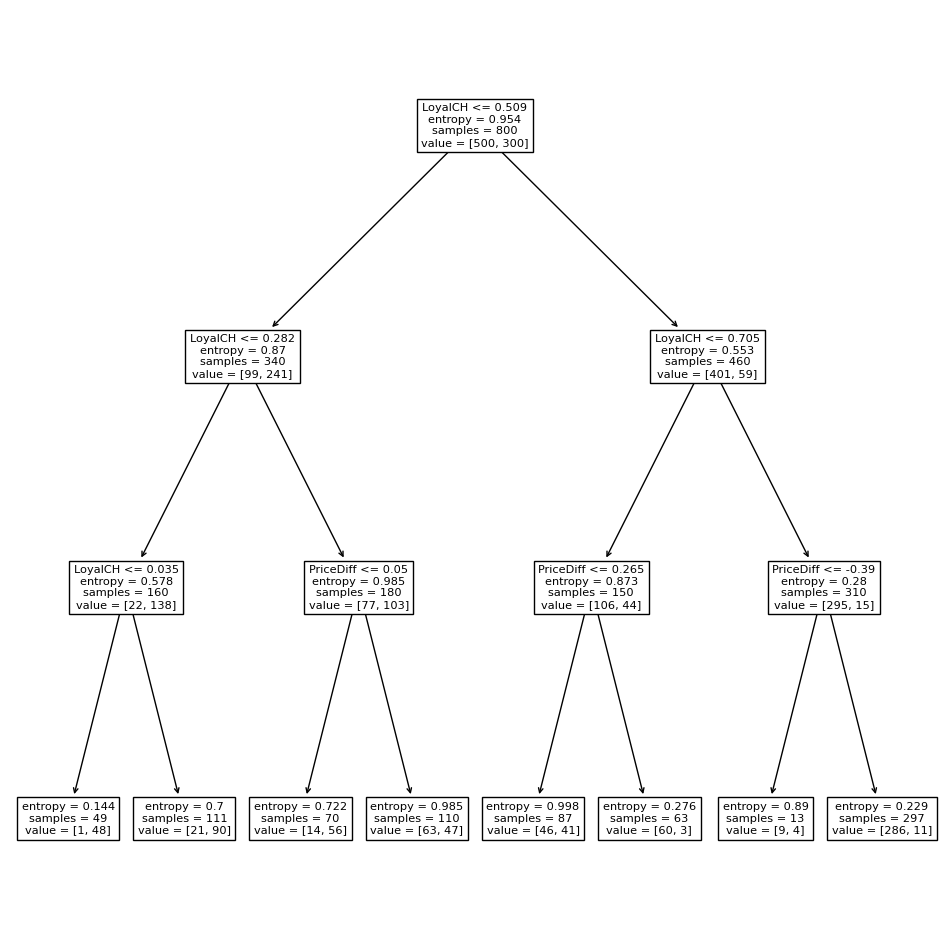

In [43]:
ax = subplots(figsize=(12, 12))[1]
plot_tree(clf_pruned,feature_names=feature_names,ax=ax);

### (j)

In [44]:
training_error_pruned=1-accuracy_score(y_train, clf_pruned.predict(X_train))
training_error_pruned

0.1775

The training error is 17.75% way larger than the training error obtained with the full tree. This was expected as in question (b) there was overfit.

### (k)

In [45]:
test_error_pruned=1-accuracy_score(y_test,clf_pruned.predict(X_test))
test_error_pruned

0.18888888888888888

Now the test error is better (18,88%) than the test error obtained with the full tree (22,22%).

## Exercise 10

In [2]:
Hitters=load_data('Hitters')

In [3]:
Hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

In [5]:
Hitters=Hitters.dropna()

In [6]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [7]:
Hitters['League'].unique()

['N', 'A']
Categories (2, object): ['A', 'N']

In [8]:
Hitters['Division'].unique()

['W', 'E']
Categories (2, object): ['E', 'W']

In [9]:
Hitters['NewLeague'].unique()

['N', 'A']
Categories (2, object): ['A', 'N']

### (a)

In [10]:
Hitters['League']=np.where(Hitters['League']=='A',1,0)
Hitters['Division']=np.where(Hitters['Division']=='E',1,0)
Hitters['NewLeague']=np.where(Hitters['NewLeague']=='A',1,0)

In [12]:
Hitters['LogSalary']=np.log(Hitters['Salary'])

In [13]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,LogSalary
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,0,0,632,43,10,475.0,0,6.163315
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,1,0,880,82,14,480.0,1,6.173786
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,0,1,200,11,3,500.0,0,6.214608
4,321,87,10,39,42,30,2,396,101,12,...,46,33,0,1,805,40,4,91.5,0,4.516339
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,1,0,282,421,25,750.0,1,6.620073


### (b)

In [16]:
X=Hitters.drop(['Salary','LogSalary'],axis=1)
y=Hitters['LogSalary']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,y,train_size=200,
                                                          random_state=1)

### (c)

In [33]:
lambdagrid=np.linspace(0.001,0.04)#Typical values of lambda range between 0.001 and 0.01 according to
# page 349 of the book. We chose 0.04 insetead of 0.01 to show the stabilization of training MSE
training_mse=np.zeros(lambdagrid.shape[0])
for i in range(lambdagrid.shape[0]):
    boost_Hitters = GBR(n_estimators=1000,learning_rate=lambdagrid[i],random_state=3)
    boost_Hitters.fit(X_train, y_train)
    training_mse[i] = np.mean((y_train- boost_Hitters.predict(X_train))**2)

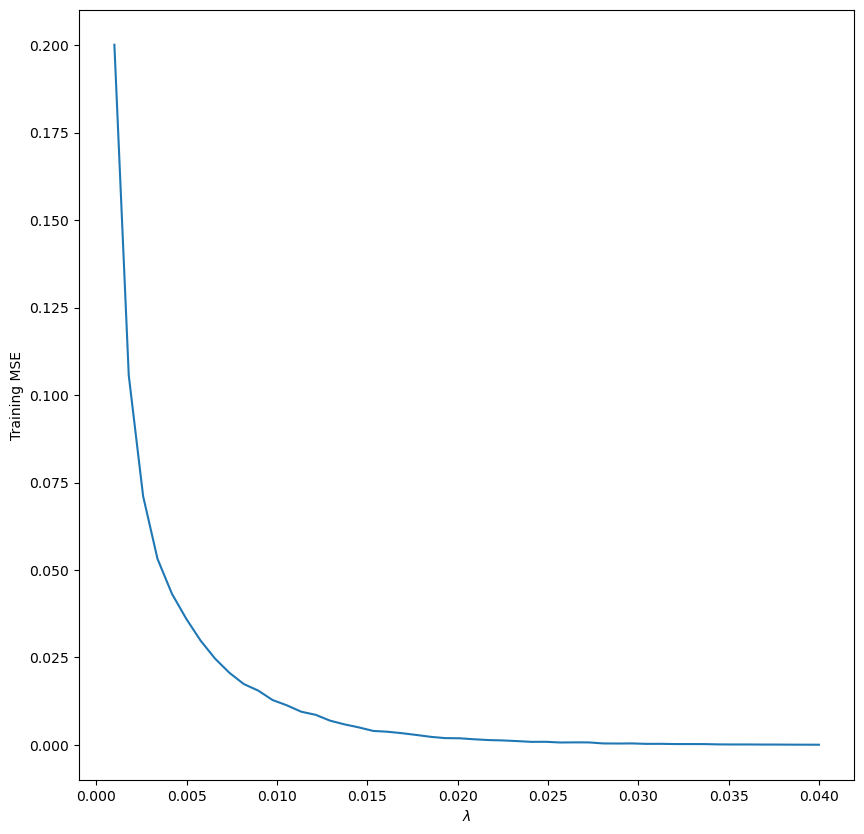

In [34]:
fig,ax=subplots(figsize=(10,10))
ax.plot(lambdagrid,training_mse)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Training MSE');

### (d)

In [36]:
test_mse=np.zeros(lambdagrid.shape[0])
for i in range(lambdagrid.shape[0]):
    boost_Hitters = GBR(n_estimators=1000,learning_rate=lambdagrid[i],random_state=3)
    boost_Hitters.fit(X_train, y_train)
    test_mse[i] = np.mean((y_test- boost_Hitters.predict(X_test))**2)


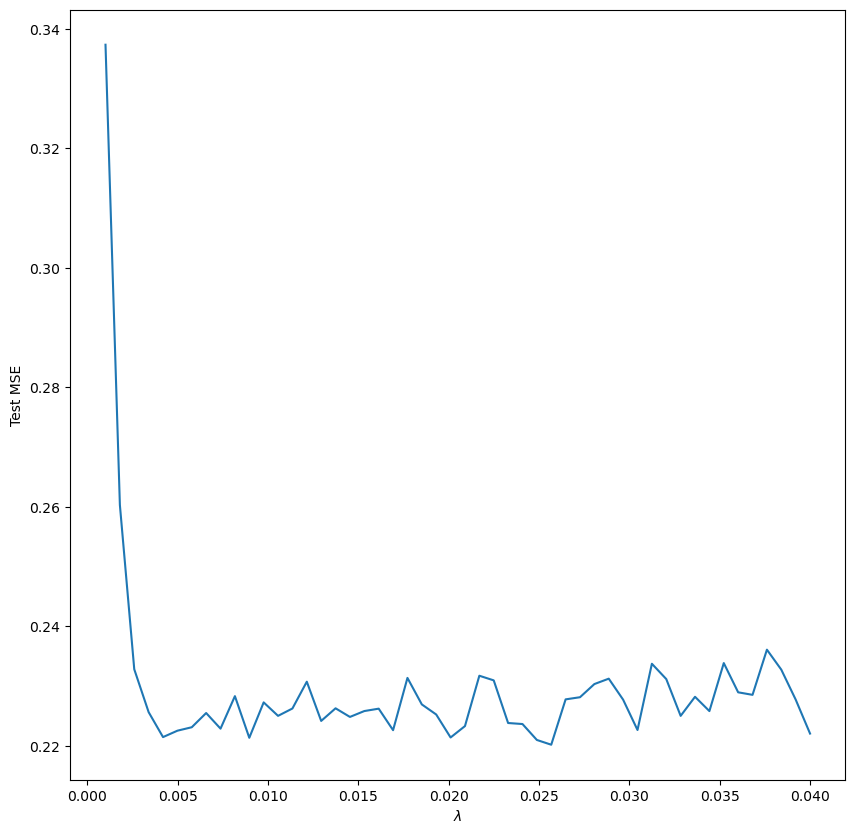

In [37]:
fig,ax=subplots(figsize=(10,10))
ax.plot(lambdagrid,test_mse)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Test MSE');

### (e)

In [40]:
#Multiple linear regression
mlr_Hitters=LinearRegression().fit(X_train, y_train)
mlr_testmse=np.mean((y_test- mlr_Hitters.predict(X_test))**2)

In [41]:
#Ridge regression
ridge_Hitters=Ridge().fit(X_train,y_train)
ridge_testmse=np.mean((y_test- ridge_Hitters.predict(X_test))**2)

In [44]:
# Display a barplot which places different test MSE next to each other
model=['Multiple linear regression','Ridge','Boosting']
df=pd.DataFrame({'Test Mse':[mlr_testmse,ridge_testmse,min(test_mse)]},index=model)
df

,Test Mse
Multiple linear regression,0.452639
Ridge,0.454074
Boosting,0.220185


The optimal test MSE obtained by boosting is half the test MSE obtained by both multiple linear regression and Ridge regression.

### (f)

In [48]:
# Before looking for the most important features we should first refit the boosting model with 
# the optimal lambda value
best_lmabda=lambdagrid[test_mse.argmin()]
boost_Hitters_opt = GBR(n_estimators=1000,learning_rate=best_lmabda,random_state=10)
boost_Hitters_opt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.025673469387755103, n_estimators=1000,
                          random_state=10)

In [49]:
X_train.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [50]:
feature_names=X_train.columns
feature_imp = pd.DataFrame({'importance':boost_Hitters_opt.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
CAtBat,0.436033
CHits,0.169179
AtBat,0.063362
CHmRun,0.062273
RBI,0.041733
CRBI,0.036453
CRuns,0.033348
CWalks,0.029465
Hits,0.024916
PutOuts,0.021996


The top 3 features by importance are: CAtBat, CHits and AtBat.

### (g)

In [51]:
bag_Hitters = RF(max_features=X_train.shape[1], random_state=10)
bag_Hitters.fit(X_train, y_train)

RandomForestRegressor(max_features=19, random_state=10)

In [52]:
bag_MSE=np.mean((y_test - bag_Hitters.predict(X_test))**2)
bag_MSE

0.2502380573947847

The test MSE obtained by bagging is 0.25, which slightly larger than the one obtained with boosting.

## Exercise 11

In [11]:
Caravan=load_data('Caravan')

In [12]:
Caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MOSTYPE   5822 non-null   int64 
 1   MAANTHUI  5822 non-null   int64 
 2   MGEMOMV   5822 non-null   int64 
 3   MGEMLEEF  5822 non-null   int64 
 4   MOSHOOFD  5822 non-null   int64 
 5   MGODRK    5822 non-null   int64 
 6   MGODPR    5822 non-null   int64 
 7   MGODOV    5822 non-null   int64 
 8   MGODGE    5822 non-null   int64 
 9   MRELGE    5822 non-null   int64 
 10  MRELSA    5822 non-null   int64 
 11  MRELOV    5822 non-null   int64 
 12  MFALLEEN  5822 non-null   int64 
 13  MFGEKIND  5822 non-null   int64 
 14  MFWEKIND  5822 non-null   int64 
 15  MOPLHOOG  5822 non-null   int64 
 16  MOPLMIDD  5822 non-null   int64 
 17  MOPLLAAG  5822 non-null   int64 
 18  MBERHOOG  5822 non-null   int64 
 19  MBERZELF  5822 non-null   int64 
 20  MBERBOER  5822 non-null   int64 
 21  MBERMIDD  5822

### (a)

In [13]:
model = MS(Caravan.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(Caravan)
feature_names = list(D.columns)
X = np.asarray(D)

In [14]:
y=Caravan['Purchase']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,y,train_size=1000,random_state=1)

### (b)

In [16]:
boost_Caravan = GBC(n_estimators=1000,learning_rate=0.01,random_state=3)
boost_Caravan.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=3)

In [17]:
feature_imp = pd.DataFrame({'importance':boost_Caravan.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
MGODOV,0.061780
PPERSAUT,0.059952
AFIETS,0.057126
APERSAUT,0.055229
MBERARBG,0.039077
...,...
AVRAAUT,0.000000
PPERSONG,0.000000
ABESAUT,0.000000
PZEILPL,0.000000


The top 3 features by importance are: MGODOV, PPERSAUT and AFIETS.

### (c)

In [49]:
#Find post probabilites and define new classes according to the intructions
ypred=boost_Caravan.predict_proba(X_test)

In [50]:
ypred=ypred[:,1]

In [51]:
ypred=np.where(ypred>0.2,'Yes','No')
confusion_boost = confusion_table(y_test, ypred)

In [52]:
confusion_boost

Truth,No,Yes
Predicted,,
No,4292,241
Yes,240,49


In [62]:
49/(240+49)

0.1695501730103806

Accordingly to the confusion table obtained by boosting there is 16.95% who truly purchased the product in comparison with those predicted to do so.

In [69]:
#Fit logit
(Caravan_train, Caravan_test) = skm.train_test_split(Caravan,train_size=1000,random_state=1)

In [77]:
design = MS(Caravan_train.columns.drop(['Purchase']),intercept=False)
X_train_lk = design.fit_transform(Caravan_train)
y_train_lk = Caravan_train.Purchase == 'Yes'
glm = sm.GLM(y_train_lk,X_train_lk,family=sm.families.Binomial())
results = glm.fit()

,coef,std err,z,P>|z|
MOSTYPE,0.0051,0.126,0.041,0.967
MAANTHUI,-0.3717,0.605,-0.614,0.539
MGEMOMV,0.3373,0.400,0.843,0.399
MGEMLEEF,-0.4008,0.277,-1.446,0.148
MOSHOOFD,0.0408,0.564,0.072,0.942
...,...,...,...,...
AZEILPL,-10.3345,65500.000,-0.000,1.000
APLEZIER,21.2280,131000.000,0.000,1.000
AFIETS,2.2304,1.461,1.527,0.127
AINBOED,-24.1049,193000.000,-0.000,1.000


In [79]:
ypred_logit=np.where(results.predict(X_test)>0.2,'Yes','No')
confusion_logit = confusion_table(y_test, ypred_logit)

In [80]:
confusion_logit

Truth,No,Yes
Predicted,,
No,4190,343
Yes,235,54


In [81]:
54/(54+235)

0.18685121107266436

For the logit: 18.68% predicted to purchase actually purchased.

In [95]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_lk, y_train_lk)
knn_pred_prob = knn.predict_proba(X_test)[:,1]
knn_pred=np.where(knn_pred_prob>0.2,'Yes','No')
confusion_table(knn_pred, y_test)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Truth,No,Yes
Predicted,,
No,4384,253
Yes,149,36


In [96]:
36/(149+36)

0.1945945945945946

For KNN: 19.46% predicted to purchase actually purchased. KNN is the best model in this case.

## Exercise 12

We choose to load Weekly data set in this exercise.

In [98]:
#instructions: fit to boosting, bagging, RF and BART
# look for test set performance using deviance
# Compare with logistic regression and give the best model

In [2]:
Weekly=load_data('Weekly')

In [3]:
Weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


In [5]:
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [185]:
# We will cpnsider Direction as the response and all other features as dependant variables
model = MS(Weekly.columns.drop(['Direction','Today']), intercept=False)#We drop 'Today' feature too 
# cause it is clearly correlated with Direction. Whenever Today is positive, Direction is up
D = model.fit_transform(Weekly)
feature_names = list(D.columns)
X = np.asarray(D)

In [206]:
y=Weekly['Direction']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,y,train_size=0.7,random_state=30)

In [198]:
#Boosting
boost_Weekly = GBC(n_estimators=1000,learning_rate=0.001,random_state=1,max_depth=1)
boost_Weekly.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.001, max_depth=1, n_estimators=1000,
                           random_state=1)

In [199]:
ypred = boost_Weekly.predict(X_test)

In [200]:
confusion_boost=confusion_table(y_test,ypred)

In [201]:
confusion_boost

Truth,Down,Up
Predicted,,
Down,1,142
Up,0,184


In [202]:
142/np.sum(np.sum(confusion_boost))

0.43425076452599387

We obtain a test error of 43.42%

In [217]:
#Bagging
bag_weekly = RF(max_features=X_train.shape[1], random_state=1)
y_train=np.where(y_train=='Up',1,0)
bag_weekly.fit(X_train, y_train)

RandomForestRegressor(max_features=7, random_state=1)

In [228]:
ypred = bag_weekly.predict(X_test)
y_pred=np.where(ypred>0.5,'Up','Down')
confusion_bagging=confusion_table(y_test,y_pred)

In [229]:
confusion_bagging

Truth,Down,Up
Predicted,,
Down,59,84
Up,60,124


In [231]:
(60+84)/np.sum(np.sum(confusion_bagging))

0.44036697247706424

Bagging yileds to a classification error of 44%.

In [232]:
#Random forests with sqrt features supposed to be optimal
RF_weekly=RF(max_features='sqrt',random_state=30).fit(X_train,y_train)


In [240]:
ypred = RF_weekly.predict(X_test)
y_pred=np.where(ypred>0.5,'Up','Down')
confusion_RF=confusion_table(y_test,y_pred)

In [234]:
confusion_RF

Truth,Down,Up
Predicted,,
Down,55,88
Up,59,125


In [235]:
(88+59)/np.sum(np.sum(confusion_RF))

0.44954128440366975

Random forests yiled to a classification error of 45%.

In [236]:
#Logistic regression
glm = sm.GLM(y_train,X_train,family=sm.families.Binomial())
results = glm.fit()

In [237]:
ypred = results.predict(X_test)
y_pred=np.where(ypred>0.5,'Up','Down')
confusion_logit=confusion_table(y_test,y_pred)

In [238]:
confusion_logit

Truth,Down,Up
Predicted,,
Down,22,121
Up,18,166


In [239]:
(18+121)/np.sum(np.sum(confusion_logit))

0.42507645259938837

Logistic regression yields to a classification error of 42.5%. Thus, it is the most performant model in this case. But overall, models have nearly the same performance.